In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

In [2]:
import pandas as pd
from tqdm import tqdm

# Loading Audio MetaData

In [3]:
def feature_extraction(file_path):
    audio, sample_rate = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
    mfcc_scaled = np.mean(mfcc.T, axis=0)
    return mfcc_scaled

## Extracting Features

In [4]:
# Feature extraction was performed and the features were extracted and saved to a pickle file.

# df = pd.read_csv('meta.csv')
# dataset_path = 'public_dataset/'

# df = df[:8000] # Taking only 8k audio files

# extracted_features = []

# for index_num, row in tqdm(df.iterrows()):
#    file_name = dataset_path + row['uuid'] + '.wav'
#    labels = row['classID']
#    data = feature_extraction(file_name)
#    extracted_features.append([data, labels])

# extracted_features = pd.DataFrame(extracted_features, columns=['Feature', 'Class'])
# print(extracted_features)

In [5]:
# -> already executed once
# extracted_features.to_pickle('mfcc_features.pkl')

extracted_features = pd.read_pickle('mfcc_features.pkl')
extracted_features

,Feature,Class
0,"[-620.2583, 61.49415, -15.288396, 14.906147, -...",0.0
1,"[-563.3379, 18.238453, -2.3402789, 5.720763, -...",1.0
2,"[-736.4029, 55.818638, 9.05353, 1.8999938, -12...",0.0
3,"[-278.87955, 100.88817, -25.865995, 15.782074,...",1.0
4,"[-1131.3711, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.0
...,...,...
7995,"[-413.21313, 46.74795, -24.516472, 14.378974, ...",0.0
7996,"[-306.65973, 108.84736, -32.75348, 26.687147, ...",0.0
7997,"[-460.42007, 44.10028, -8.913488, 6.1871886, -...",1.0
7998,"[-433.1279, 35.696888, -21.607098, 1.155598, -...",1.0


In [6]:
X = np.array(extracted_features['Feature'].to_list())
y = np.array(extracted_features['Class'].to_list())

In [7]:
X.shape, y.shape

((8000, 50), (8000,))

# Splitting DataSet

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [10]:
X_train.shape, y_train.shape

((6400, 50), (6400,))

# CREATING THE MODEL

In [11]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

## Building Layers

In [13]:
model = Sequential()
model.add(Dense(64, input_dim=len(X[0, :]), activation = 'relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


## Training

In [15]:
model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [16]:
model.fit(x=X_train, y=y_train, epochs=256, verbose=1)

Epoch 1/256


2024-10-26 19:19:46.954670: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


200/200 [==============================] - 0s 509us/step - loss: 1.7042 - accuracy: 0.5841
Epoch 2/256
200/200 [==============================] - 0s 464us/step - loss: 1.0650 - accuracy: 0.6361
Epoch 3/256
200/200 [==============================] - 0s 464us/step - loss: 0.8978 - accuracy: 0.6641
Epoch 4/256
200/200 [==============================] - 0s 457us/step - loss: 0.8701 - accuracy: 0.6728
Epoch 5/256
200/200 [==============================] - 0s 452us/step - loss: 0.7856 - accuracy: 0.6772
Epoch 6/256
200/200 [==============================] - 0s 458us/step - loss: 0.7246 - accuracy: 0.6928
Epoch 7/256
200/200 [==============================] - 0s 455us/step - loss: 0.6956 - accuracy: 0.6977
Epoch 8/256
200/200 [==============================] - 0s 454us/step - loss: 0.6767 - accuracy: 0.7031
Epoch 9/256
200/200 [==============================] - 0s 453us/step - loss: 0.6474 - accuracy: 0.7023
Epoch 10/256
200/200 [==============================] - 0s 459us/step - loss: 0.5925 

## Testing

In [17]:
test_evaluation = model.evaluate(X_test, y_test, verbose=1)
test_evaluation[1]

50/50 [==============================] - 0s 448us/step - loss: 1.6678 - accuracy: 0.7856


0.7856249809265137

In [18]:
from sklearn.metrics import accuracy_score

model_accuracy = accuracy_score(y_test, model.predict(X_test).round())
model_accuracy

50/50 [==============================] - 0s 378us/step


0.785625

# IMPROVING ACCURACY

## BETTER_MODEL

In [24]:
from tensorflow.keras.regularizers import l2

In [25]:
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

model_2 = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]),
          kernel_regularizer=l2(0.01)),
    
    MaxPooling1D(2),
    
    Conv1D(64, 3, activation='relu',
          kernel_regularizer=l2(0.01)),
    
    MaxPooling1D(2),
    Flatten(),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [26]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense_3 (Dense)             (None, 64)               

## Train

In [27]:
%%capture --no-stdout
import tensorflow_addons as tfa

In [54]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

history = model_2.fit(x=X_train, y=y_train, batch_size=64,epochs=124, verbose=0, callbacks=[tqdm_callback], validation_data=(X_test, y_test))

Training:   0%|                                        0/124 ETA: ?s,  ?epochs/s

Epoch 1/124


0/100                                                                 ETA: ?s - 

Epoch 2/124


0/100                                                                 ETA: ?s - 

Epoch 3/124


0/100                                                                 ETA: ?s - 

Epoch 4/124


0/100                                                                 ETA: ?s - 

Epoch 5/124


0/100                                                                 ETA: ?s - 

Epoch 6/124


0/100                                                                 ETA: ?s - 

Epoch 7/124


0/100                                                                 ETA: ?s - 

Epoch 8/124


0/100                                                                 ETA: ?s - 

Epoch 9/124


0/100                                                                 ETA: ?s - 

Epoch 10/124


0/100                                                                 ETA: ?s - 

Epoch 11/124


0/100                                                                 ETA: ?s - 

Epoch 12/124


0/100                                                                 ETA: ?s - 

Epoch 13/124


0/100                                                                 ETA: ?s - 

Epoch 14/124


0/100                                                                 ETA: ?s - 

Epoch 15/124


0/100                                                                 ETA: ?s - 

Epoch 16/124


0/100                                                                 ETA: ?s - 

Epoch 17/124


0/100                                                                 ETA: ?s - 

Epoch 18/124


0/100                                                                 ETA: ?s - 

Epoch 19/124


0/100                                                                 ETA: ?s - 

Epoch 20/124


0/100                                                                 ETA: ?s - 

Epoch 21/124


0/100                                                                 ETA: ?s - 

Epoch 22/124


0/100                                                                 ETA: ?s - 

Epoch 23/124


0/100                                                                 ETA: ?s - 

Epoch 24/124


0/100                                                                 ETA: ?s - 

Epoch 25/124


0/100                                                                 ETA: ?s - 

Epoch 26/124


0/100                                                                 ETA: ?s - 

Epoch 27/124


0/100                                                                 ETA: ?s - 

Epoch 28/124


0/100                                                                 ETA: ?s - 

Epoch 29/124


0/100                                                                 ETA: ?s - 

Epoch 30/124


0/100                                                                 ETA: ?s - 

Epoch 31/124


0/100                                                                 ETA: ?s - 

Epoch 32/124


0/100                                                                 ETA: ?s - 

Epoch 33/124


0/100                                                                 ETA: ?s - 

Epoch 34/124


0/100                                                                 ETA: ?s - 

Epoch 35/124


0/100                                                                 ETA: ?s - 

Epoch 36/124


0/100                                                                 ETA: ?s - 

Epoch 37/124


0/100                                                                 ETA: ?s - 

Epoch 38/124


0/100                                                                 ETA: ?s - 

Epoch 39/124


0/100                                                                 ETA: ?s - 

Epoch 40/124


0/100                                                                 ETA: ?s - 

Epoch 41/124


0/100                                                                 ETA: ?s - 

Epoch 42/124


0/100                                                                 ETA: ?s - 

Epoch 43/124


0/100                                                                 ETA: ?s - 

Epoch 44/124


0/100                                                                 ETA: ?s - 

Epoch 45/124


0/100                                                                 ETA: ?s - 

Epoch 46/124


0/100                                                                 ETA: ?s - 

Epoch 47/124


0/100                                                                 ETA: ?s - 

Epoch 48/124


0/100                                                                 ETA: ?s - 

Epoch 49/124


0/100                                                                 ETA: ?s - 

Epoch 50/124


0/100                                                                 ETA: ?s - 

Epoch 51/124


0/100                                                                 ETA: ?s - 

Epoch 52/124


0/100                                                                 ETA: ?s - 

Epoch 53/124


0/100                                                                 ETA: ?s - 

Epoch 54/124


0/100                                                                 ETA: ?s - 

Epoch 55/124


0/100                                                                 ETA: ?s - 

Epoch 56/124


0/100                                                                 ETA: ?s - 

Epoch 57/124


0/100                                                                 ETA: ?s - 

Epoch 58/124


0/100                                                                 ETA: ?s - 

Epoch 59/124


0/100                                                                 ETA: ?s - 

Epoch 60/124


0/100                                                                 ETA: ?s - 

Epoch 61/124


0/100                                                                 ETA: ?s - 

Epoch 62/124


0/100                                                                 ETA: ?s - 

Epoch 63/124


0/100                                                                 ETA: ?s - 

Epoch 64/124


0/100                                                                 ETA: ?s - 

Epoch 65/124


0/100                                                                 ETA: ?s - 

Epoch 66/124


0/100                                                                 ETA: ?s - 

Epoch 67/124


0/100                                                                 ETA: ?s - 

Epoch 68/124


0/100                                                                 ETA: ?s - 

Epoch 69/124


0/100                                                                 ETA: ?s - 

Epoch 70/124


0/100                                                                 ETA: ?s - 

Epoch 71/124


0/100                                                                 ETA: ?s - 

Epoch 72/124


0/100                                                                 ETA: ?s - 

Epoch 73/124


0/100                                                                 ETA: ?s - 

Epoch 74/124


0/100                                                                 ETA: ?s - 

Epoch 75/124


0/100                                                                 ETA: ?s - 

Epoch 76/124


0/100                                                                 ETA: ?s - 

Epoch 77/124


0/100                                                                 ETA: ?s - 

Epoch 78/124


0/100                                                                 ETA: ?s - 

Epoch 79/124


0/100                                                                 ETA: ?s - 

Epoch 80/124


0/100                                                                 ETA: ?s - 

Epoch 81/124


0/100                                                                 ETA: ?s - 

Epoch 82/124


0/100                                                                 ETA: ?s - 

Epoch 83/124


0/100                                                                 ETA: ?s - 

Epoch 84/124


0/100                                                                 ETA: ?s - 

Epoch 85/124


0/100                                                                 ETA: ?s - 

Epoch 86/124


0/100                                                                 ETA: ?s - 

Epoch 87/124


0/100                                                                 ETA: ?s - 

Epoch 88/124


0/100                                                                 ETA: ?s - 

Epoch 89/124


0/100                                                                 ETA: ?s - 

Epoch 90/124


0/100                                                                 ETA: ?s - 

Epoch 91/124


0/100                                                                 ETA: ?s - 

Epoch 92/124


0/100                                                                 ETA: ?s - 

Epoch 93/124


0/100                                                                 ETA: ?s - 

Epoch 94/124


0/100                                                                 ETA: ?s - 

Epoch 95/124


0/100                                                                 ETA: ?s - 

Epoch 96/124


0/100                                                                 ETA: ?s - 

Epoch 97/124


0/100                                                                 ETA: ?s - 

Epoch 98/124


0/100                                                                 ETA: ?s - 

Epoch 99/124


0/100                                                                 ETA: ?s - 

Epoch 100/124


0/100                                                                 ETA: ?s - 

Epoch 101/124


0/100                                                                 ETA: ?s - 

Epoch 102/124


0/100                                                                 ETA: ?s - 

Epoch 103/124


0/100                                                                 ETA: ?s - 

Epoch 104/124


0/100                                                                 ETA: ?s - 

Epoch 105/124


0/100                                                                 ETA: ?s - 

Epoch 106/124


0/100                                                                 ETA: ?s - 

Epoch 107/124


0/100                                                                 ETA: ?s - 

Epoch 108/124


0/100                                                                 ETA: ?s - 

Epoch 109/124


0/100                                                                 ETA: ?s - 

Epoch 110/124


0/100                                                                 ETA: ?s - 

Epoch 111/124


0/100                                                                 ETA: ?s - 

Epoch 112/124


0/100                                                                 ETA: ?s - 

Epoch 113/124


0/100                                                                 ETA: ?s - 

Epoch 114/124


0/100                                                                 ETA: ?s - 

Epoch 115/124


0/100                                                                 ETA: ?s - 

Epoch 116/124


0/100                                                                 ETA: ?s - 

Epoch 117/124


0/100                                                                 ETA: ?s - 

Epoch 118/124


0/100                                                                 ETA: ?s - 

Epoch 119/124


0/100                                                                 ETA: ?s - 

Epoch 120/124


0/100                                                                 ETA: ?s - 

Epoch 121/124


0/100                                                                 ETA: ?s - 

Epoch 122/124


0/100                                                                 ETA: ?s - 

Epoch 123/124


0/100                                                                 ETA: ?s - 

Epoch 124/124


0/100                                                                 ETA: ?s - 

### Check Overfit

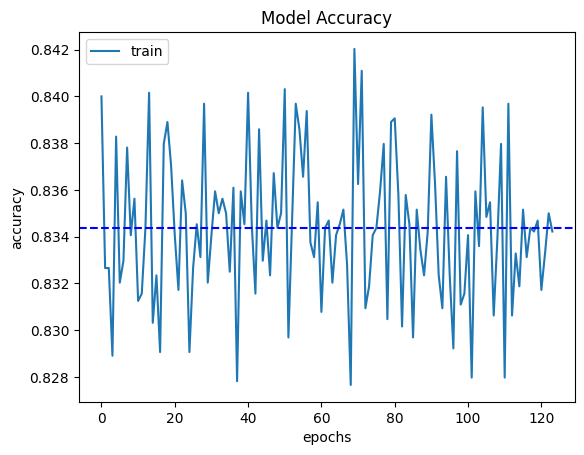

In [55]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper left')
plt.axhline(np.nanmean(history.history['accuracy']), color='b', linestyle='--')
plt.show()

### Accuracy

In [56]:
model2_accuracy = accuracy_score(y_test, model_2.predict(X_test).round())
model2_accuracy

50/50 [==============================] - 0s 850us/step


0.8225

# PREDICTIONS

In [48]:
test_features = []

for file in os.listdir('./test_samples/'):
    if (file == '.DS_Store'):
        continue
    mfcc = feature_extraction(f"./test_samples/{file}")
    test_features.append(mfcc)

test_features = np.array(test_features)

In [69]:
result1 = model.predict(test_features)
result2 = model_2.predict(test_features)
label = [1, 1, 1, 1, 0]

pred = pd.DataFrame(result1, columns=['Model 1'])
pred['Model 2'] = result2
pred['Original'] = label

pred

1/1 [==============================] - 0s 12ms/step


,Model 1,Model 2,Original
0,2.398355e-04,0.753382,1
1,9.923248e-01,0.731731,1
2,1.542115e-16,0.110656,1
3,9.999946e-01,0.482454,1
4,4.845956e-29,0.110362,0
